In [ ]:
# Install imbalanced-learn for SMOTE
!pip install imbalanced-learn

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Change path accordingly
df = pd.read_csv("/content/drive/MyDrive/Machine Learning Datasets/creditcard.csv")

print(df.shape)
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# Scale Amount and Time
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))
df.drop(['Time','Amount'], axis=1, inplace=True)

# Separate features & target
X = df.drop('Class', axis=1)
y = df['Class']

print("Fraud cases:", sum(y))
print("Normal cases:", len(y)-sum(y))


Fraud cases: 492
Normal cases: 284315


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Oversample minority + undersample majority
over = SMOTE(sampling_strategy=0.1, random_state=42)   # frauds become 10% of normals
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42) # reduce majority
steps = [('over', over), ('under', under)]
resample_pipeline = Pipeline(steps=steps)

X_res, y_res = resample_pipeline.fit_resample(X_train, y_train)

print("Before resampling:", Counter(y_train))
print("After resampling:", Counter(y_res))


Before resampling: Counter({0: 227451, 1: 394})
After resampling: Counter({0: 45490, 1: 22745})


In [ ]:
# Base models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
gb = GradientBoostingClassifier()

# Ensemble (soft voting)
ensemble = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('gb', gb)],
    voting='soft'
)

# Train
ensemble.fit(X_res, y_res)

# Predictions
y_pred = ensemble.predict(X_test)
y_proba = ensemble.predict_proba(X_test)[:,1]


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:43:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.54      0.89      0.67        98

    accuracy                           1.00     56962
   macro avg       0.77      0.94      0.84     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.9801793466401755


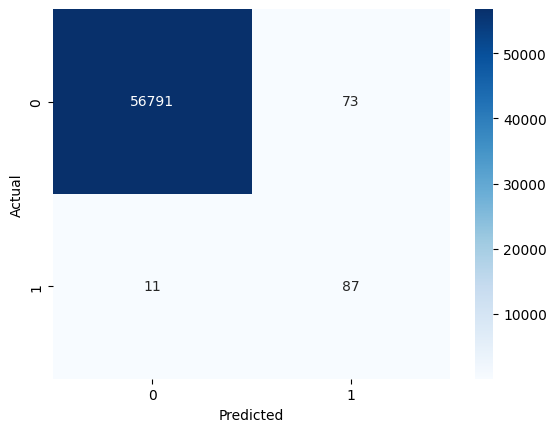

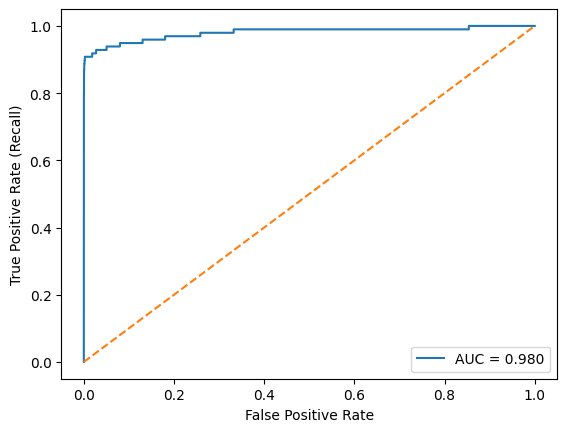

In [ ]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label="AUC = %.3f" % auc(fpr, tpr))
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend()
plt.show()
